In [109]:
# Connect to Azure Machine Learning Workspace 
import sys
import os
import json
import archai.common.azureml_helper as aml_helper
from azure.ai.ml.entities import UserIdentityConfiguration

sys.path.append(os.path.realpath('scripts'))

from cnn_search_space import CNNSearchSpace

# make sure we have a scripts dir for the code to run our jobs.
import os
scripts_dir = "./scripts"
os.makedirs(scripts_dir, exist_ok=True)

config_file = "../.azureml/config.json"
config = json.load(open(config_file, 'r'))

for required_key in ['subscription_id', 'resource_group', 'workspace_name', 'storage_account_key', 'storage_account_name']:
    if not required_key in config:
        print(f"### Error: please add a {required_key} to {config_file}")

storage_account_key = config['storage_account_key']    
storage_account_name = config['storage_account_name']

print(f'Using storage account: {storage_account_name}')

# This is the AML experiment name 
experiment_name = 'mnist_test_run'

Using storage account: archaimnistmodels


In [110]:
# Get a handle to the workspace
ml_client = aml_helper.get_aml_client_from_file(config_path=config_file)
print(f'Using workspace "{ml_client.workspace_name}" in resource group "{ml_client.resource_group_name}"')
print(f'Using subscription "{ml_client.subscription_id}"')

Found the config file in: ..\.azureml\config.json


Using workspace "snpe-aml-workspace" in resource group "snpe-aml-rg"
Using subscription "c8b7f913-60fb-4759-a310-fc5630e56f99"


In [111]:
# Create cpu cluster for running the search
cpu_compute_name = "nas-cpu-cluster-D14-v2"
aml_helper.create_compute_cluster(ml_client, cpu_compute_name, size="Standard_D14_v2", location="westus2")

# Create gpu cluster for running the search
gpu_compute_name = "nas-gpu-cluster-NC6"
aml_helper.create_compute_cluster(ml_client, gpu_compute_name, size="Standard_NC6", location="westus2", max_instances=8)

You already have a cluster named nas-cpu-cluster-D14-v2, we'll reuse it as is.
You already have a cluster named nas-gpu-cluster-NC6, we'll reuse it as is.


In [112]:
archai_job_env = aml_helper.create_environment_from_file(ml_client, conda_file="conda.yaml", version='0.1.5')

Environment with name aml-archai is registered to workspace, the environment version is 0.1.5


In [131]:
from store import ArchaiStore

# Register the datastore with AML
data_store_name = "datasets"
data_container_name = "datasets"
model_store_name = "models"
model_container_name = "models"
root_folder = "MNIST"

# make sure the datasets container exists
store = ArchaiStore(storage_account_name, storage_account_key, blob_container_name=data_container_name)
store.upload_blob(root_folder, config_file)

# make sure the models container exists
store = ArchaiStore(storage_account_name, storage_account_key, blob_container_name=model_container_name)
store.upload_blob("config", config_file)

datastore_path = f'azureml://datastores/{data_store_name}/paths/{root_folder}'
results_path = f'azureml://datastores/{model_store_name}/paths/{root_folder}'


In [114]:
from azure.ai.ml.entities import AzureBlobDatastore
from azure.ai.ml.entities._credentials import AccountKeyConfiguration

try:
    model_store = ml_client.datastores.get(model_store_name)
except:
    # Register the blob store container for storing our NAS generated models in.
    model_store = AzureBlobDatastore(
        name=model_store_name,
        description="Datastore pointing to our models blob container.",
        account_name=storage_account_name,
        container_name=model_container_name,
        credentials=AccountKeyConfiguration(
            account_key=storage_account_key
        ),
    )

    ml_client.create_or_update(model_store)

In [115]:
try:
    data_store = ml_client.datastores.get(data_store_name)
except:
    data_store = AzureBlobDatastore(
        name=data_store_name,
        description="Datastore pointing to our dataset container.",
        account_name=storage_account_name,
        container_name=data_container_name,
        credentials=AccountKeyConfiguration(
            account_key=storage_account_key
        ),
    )

    ml_client.create_or_update(data_store)

In [116]:
from azure.ai.ml import command
from azure.ai.ml import Input, Output

data_prep_component = command(
    name="data_prep2",
    display_name="Data preparation for training",
    description="Downloads the remote dataset to our blob store.",
    inputs= {
        "name": Input(type='string')
    },
    outputs= {
        "data": Output(type="uri_folder", path=datastore_path, mode="rw_mount")
    },

    # The source folder of the component
    code=scripts_dir,
    command="""python3 prep_data_store.py \
            --path ${{outputs.data}} \
            """,
    environment=f"{archai_job_env.name}:{archai_job_env.version}",
)

In [160]:
environment_name = f'{archai_job_env.name}:{archai_job_env.version}'
hex_config = bytes(json.dumps(config), encoding='utf-8').hex()

output_path = results_path + '/' + experiment_name

search_component = command(
    name="search",
    display_name="The Archai NAS search",
    description="Runs the NAS search algorithm.",    
    inputs= {
        "data": Input(type="uri_folder")
    },
    outputs= {
        "results": Output(type="uri_folder", path=output_path, mode="rw_mount")
    },
    code=scripts_dir,
    identity= UserIdentityConfiguration(),
    command='python3 search.py --local_output ${{outputs.results}} ' + \
            f'--data_dir {datastore_path} ' + \
            f'--output_dir {results_path} ' + \
            f'--environment "{environment_name}" ' + \
            f'--compute "{gpu_compute_name}" ' + \
            f'--config "{hex_config}" ' + \
            f'--partial_training_epochs 1 ' + \
            f'--full_training_epochs 10 ',
    environment=f"{archai_job_env.name}:{archai_job_env.version}",
)

In [118]:
from azure.ai.ml import dsl, Input, Output

@dsl.pipeline(
    compute=cpu_compute_name,
    description="Data prep pipeline",
)
def mnist_search_pipeline():
    # using data_prep_function like a python call with its own inputs
    data_prep_job = data_prep_component(
        name="MNIST"
    )

    # check the dataset
    check_job = search_component(
        data=data_prep_job.outputs.data
    )
    
    return { "data": data_prep_job.outputs.data }

In [119]:
pipeline = mnist_search_pipeline()

# submit the pipeline job
pipeline_job = ml_client.jobs.create_or_update(
    pipeline,
    # Project's name
    experiment_name=experiment_name,
)


Uploading scripts (0.05 MBs): 100%|##########| 49334/49334 [00:01<00:00, 45123.43it/s]




In [120]:
import webbrowser
# open the pipeline in web browser
webbrowser.open(pipeline_job.services["Studio"].endpoint)

True

In [139]:
from IPython.display import display, Image

def get_results(blob_path, output_folder):
    """ Fetch the pareto fully trained models and show the results """
    os.makedirs(blob_path, exist_ok=True)
    store.download(blob_path, output_folder)

def download_models(output_folder, models):
    for id in models:
        sub_folder = os.path.join(output_folder, id)
        os.makedirs(sub_folder, exist_ok=True)
        store.download(os.path.join(experiment_name, id), sub_folder)
        
def show_results(output_folder):
    for name in os.listdir(output_folder):
        if name.endswith(".png"):
            display(Image(filename=os.path.join(output_folder, name)))
    
    results_file = os.path.join(output_folder, "results.json")
    if os.path.isfile(results_file):
        best_models = json.load(open(results_file, "r"))
        for model in best_models:
            print(f"{model}\t{model['archid']}\t{model['val_acc']}")

        download_models(output_folder, list(best_models.keys()))


## Plots

Take a look at the pareto curve plots.  This cell can be run multiple times and you will see updates as each iteration finishes.

Fetching results for mnist_test_run2...
Overall search status is: {status}


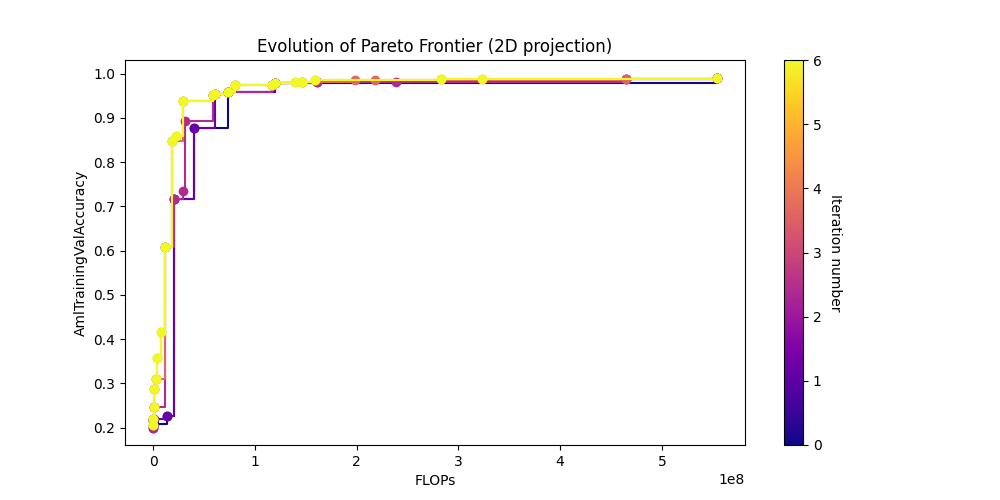

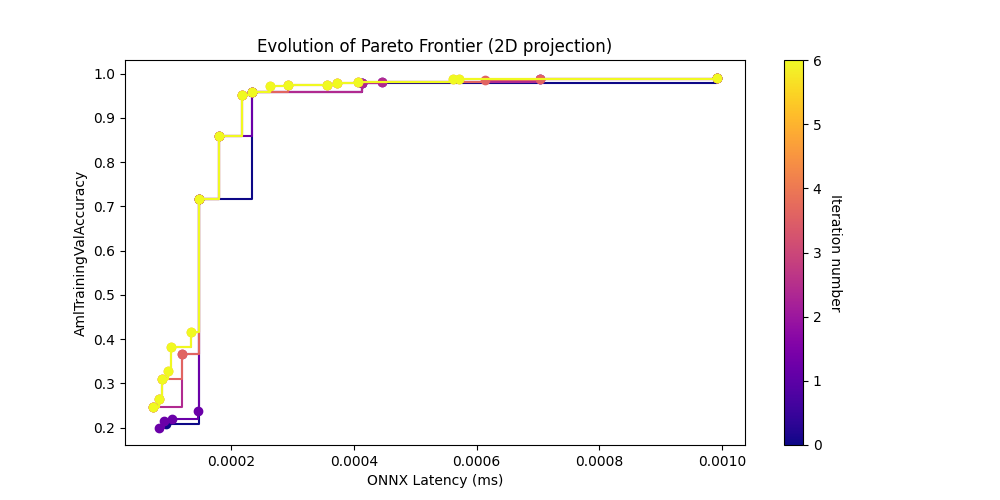

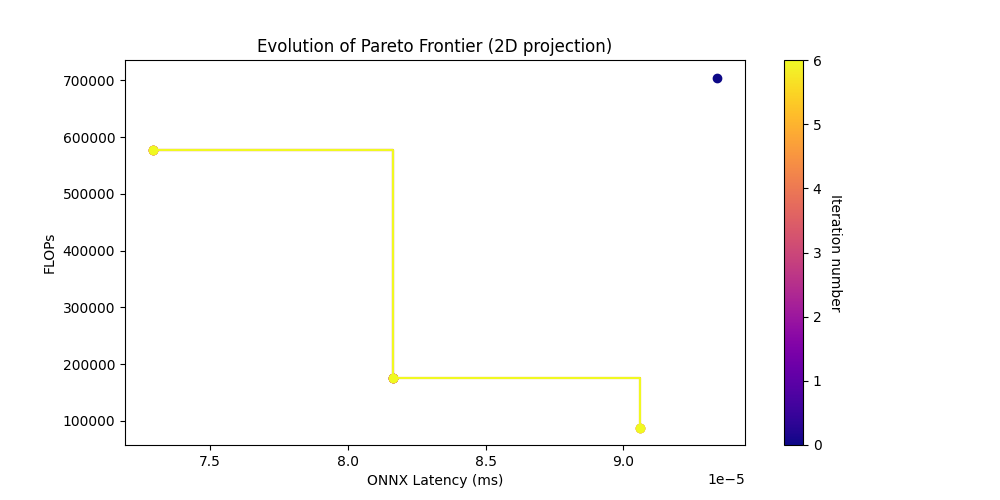

In [140]:
from store import ArchaiStore
store = ArchaiStore(storage_account_name, storage_account_key, blob_container_name=model_container_name)

print(f'Fetching results for {experiment_name}...')
blob_path = root_folder + '/' + experiment_name
status = ml_client.jobs.get(pipeline_job.name).status
output_folder = experiment_name

if status == 'Completed' or status == 'Running':
    print("Overall search status is: {status}")
    get_results(blob_path, output_folder)
    show_results(output_folder)
elif status == 'Failed':
    print('Pipeline failed')
    

## Local Inference on Top Model

When pipeline is finished we can try the top model in the ONNX runtime to see if the ONNX inference scores the same result on this model.

In [161]:
# find the top model in the json results.
filename = os.path.join(output_folder, "top_models.json")
best_of_the_best = None
top_accuracy = 0
row = None
if not os.path.isfile(filename):
    raise Exception(f"Could not find {filename} file. Please wait for job to finish.")

results = json.load(open(filename, "r"))
for key in results.keys():
    a = results[key]
    if type(a) is dict and 'val_acc' in a:
        val_acc = a['val_acc']
        if val_acc > top_accuracy:
            top_accuracy = val_acc
            best_of_the_best = key
            row = a

print(f"The top model is {best_of_the_best} with accuracy {top_accuracy} and architecture {row['archid']}")

blob_path = root_folder + '/' + best_of_the_best
model_output = os.path.join(output_folder, 'top_model')
get_results(blob_path, model_output)

model_path = os.path.join(model_output, 'model.onnx')


The top model is id_756ac7c9_8466_4975_a84d_b986b1d1ac18 with accuracy 0.9957 and architecture (9, 5, 32)


data has shape: torch.Size([28, 28])


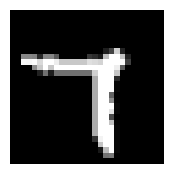

input: input, [1, 1, 28, 28], tensor(float)
Testing 10000 rows


c:\anaconda3\envs\archai\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Inference pass rate is  99.57 %.
How does this compare with the training validation accuracy of 0.9957


In [163]:
# Great, now let's test if this model works as advertised.
from archai.datasets.cv.mnist_dataset_provider import MnistDatasetProvider
import onnxruntime as ort
import numpy as np

dataset_provider = MnistDatasetProvider()
val_data = dataset_provider.get_val_dataset()
count = val_data.data.shape[0]
test = np.random.choice(count, 1)[0]
data = val_data.data[test]

import matplotlib.pyplot as plt

# check what the images look like.
plt.figure(figsize=(2,2))
plt.imshow(data, cmap='gray')
print(f'data has shape: {data.shape}')
plt.axis('off')
plt.show()

# Now run the ONNX runtime on this the validation set.
# You can change this to `CUDAExecutionProvider` if you have a GPU and have
# installed the CUDA runtime.
ort_sess = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])
for i in ort_sess.get_inputs():
    print(f'input: {i.name}, {i.shape}, {i.type}')
    
print(f'Testing {count} rows')
failed = 0
for i in range(val_data.data.shape[0]):
    data = val_data.data[i]    
    expected = int(val_data.train_labels[i])

    while len(data.shape) < 4:
        data = np.expand_dims(data, axis=0)
    outputs = ort_sess.run(None, {'input': data.astype(np.float32) / 255.0})
    result = outputs[0]
    index = np.argmax(result)
    label = val_data.classes[index]
    if expected != index:
        # print(f'### Failed: {expected} and got {label}')
        failed += 1
          
rate = (count - failed) * 100 / count
print(f'Inference pass rate is  {rate} %.')
print(f'How does this compare with the training validation accuracy of {top_accuracy}')
